# TODO:
This seems to work pretty well. We may want to retrain the the LSTM with more hidden units. I've saved the current model.

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import json

In [2]:
tracks = json.load(open("../data/groundtruth_tracks.json"))

In [3]:
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using Theano backend.


In [46]:
def buildLookbackDataset(tracks, lookback=3, skip=None):
    dataset = []
    for key, track in tracks.items():
        if skip:
            filename = "%04d.txt" % skip
            if filename in key:
                continue
        for i, pos in enumerate(track):
            if i < lookback:
                continue
            dataset.append(np.array(track[i-lookback:i+1]).ravel())
    return dataset
                
dataset = buildLookbackDataset(tracks) 
dataset = np.array(dataset)
# each row in the dataset is the x1, x2, y1, y2 
# where x1, x2 are the coordinate of previous position and y1,y2 are 
# coordinates of the next position or the location that should be predicted

In [52]:
dataset = buildLookbackDataset(tracks) 
dataset = np.array(dataset)
origdataset = dataset

In [53]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [54]:
model = Sequential()
model.add(LSTM(32, input_shape=(3,2)))
model.add(Dense(2))
model.compile(loss='mean_squared_error', optimizer='adam')
model.load_weights('window3_32h_weights.h5')

In [12]:
datapoint =  origdataset[0, :6]
print datapoint

[ 777.654416  165.681078  781.156791  165.186175  784.809185  164.670002]


In [18]:
cat = np.concatenate((datapoint, datapoint[:2]))
scaled = scaler.transform(np.matrix(cat).reshape(1,8))

[ 777.654416  165.681078  781.156791  165.186175  784.809185  164.670002
  777.654416  165.681078]
[[ 0.62446123  0.09930999  0.62646688  0.09784558  0.62939047  0.09337126
   0.62420121  0.10217015]]


In [28]:
scaled = scaled.reshape((8,))[:6]
print scaled
prediction = model.predict(scaled.reshape(1,3,2))
print prediction

[ 0.62446123  0.09930999  0.62646688  0.09784558  0.62939047  0.09337126]
[[ 0.63309491  0.09542078]]


In [31]:
back = scaler.inverse_transform(np.concatenate((scaled, prediction.ravel())).reshape(1,8))

In [35]:
print back.ravel()[6:]

[ 788.5699325   164.61939434]


In [55]:
varmodel = Sequential()
varmodel.add(LSTM(32, input_shape=(4,2)))
varmodel.add(Dense(2))
varmodel.compile(loss='mean_squared_error', optimizer='adam')
varmodel.load_weights('variance_32h_weights.h5')

In [68]:
def buildVarDataset(tracks, predTracks, variance, lookback=3):
    dataset = []
    for key, track in tracks.items():
        for i, pos in enumerate(track):
            if i < lookback:
                continue
            gt = np.array(track[i-lookback:i]).ravel()
            pred = np.array(predTracks[key][i])
            var = np.array(variance[key][i])
            row = np.concatenate((gt, pred, var))
            dataset.append(row)
    return dataset
                
origvardataset = buildVarDataset(tracks, predictedTracks, vs) 
origvardataset = np.array(origvardataset)

In [69]:
out = varmodel.predict(np.concatenate((scaled,prediction.ravel())).reshape(1,4,2))
print out

NameError: name 'scaled' is not defined

In [13]:
origvardataset[:,8] = origvardataset[:,8].clip(0,100)
origvardataset[:,9] = origvardataset[:,9].clip(0,5)
#varscaler = MinMaxScaler(feature_range=(0, 1))
#vardataset = varscaler.fit_transform(origvardataset)
vardataset = varscaler.transform(origvardataset)
print vardataset.shape

(25002, 10)


In [82]:
oldvals = np.concatenate((scaled,prediction.ravel()))
newval = np.concatenate((oldvals, out.ravel()))
var = varscaler.inverse_transform(newval.reshape(1,10))
print var.ravel()[8:]

[ 76.66875124   0.77294335]


In [78]:
#plt.hist(origvardataset[:,8].clip(0,100))
#print max(origvardataset[:,8])
origvardataset[1,:]

array([ 781.156791  ,  165.186175  ,  784.809185  ,  164.670002  ,
        788.6214485 ,  164.131158  ,  793.67494014,  165.24254523,
          1.14624034,    2.80371325])

In [9]:
# import pickle
# with open('scaler.pickle', 'w') as handle:
#     pickle.dump(scaler, handle)
# with open('varscaler.pickle', 'w') as handle:
#     pickle.dump(varscaler, handle)
import pickle
with open('scaler.pickle', 'r')  as handle:
    scaler = pickle.load(handle)
with open('varscaler.pickle', 'r')  as handle:
    varscaler = pickle.load(handle)   

In [77]:
# scaler = None
# with open('varscaler.pickle', 'r') as handle:
#     newscaler = pickle.load(handle)
# var = newscaler.inverse_transform(newval.reshape(1,10))


In [78]:
print var

[[  7.77654416e+02   1.65681078e+02   7.81156791e+02   1.65186175e+02
    7.84809185e+02   1.64670002e+02   7.98830012e+02   1.63319806e+02
    7.66687512e+01   7.72943349e-01]]


In [15]:
pred = varmodel.predict(vardataset[:,:8].reshape((vardataset.shape[0], 4,2)))

In [20]:
descale = varscaler.inverse_transform(np.concatenate((vardataset[:,:8], pred), axis=1))

(25002, 8)
(25002, 2)


In [21]:
var = descale[:,8:]

In [33]:
print np.argmin(var[:,0])
print np.argmax(var[:,0])
print np.argmin(var[:,1])
print np.argmax(var[:,1])

21306
12886
19735
7416


In [51]:
print var[21305,:]
np.set_printoptions(suppress=True)
print origvardataset[21305,:]

[-13.60166071   0.33259839]
[ 589.1407725   180.1306175   589.3754175   183.678872    589.617292
  187.3364965   590.33045652  189.63403969    0.51297392    0.03008844]


In [66]:
vs.items()[0]

(u'0020.txt133',
 [(0.0, 0.0),
  (0.0, 0.0),
  (0.0, 0.0),
  (3.0731353789843903, 0.19380354646002274),
  (0.77098745983430539, 0.018688544273664107),
  (2.6359845230958387, 0.10890173980198209),
  (3.2944825075986301, 0.089760745117856172),
  (3.3652293856267756, 0.088174566461246079),
  (3.4373288276548282, 0.086622049905947879),
  (2.7016426415275103, 0.42643340128429152),
  (3.4478890941705229, 0.18788119957221205),
  (3.4000519837966805, 0.20880778818693291),
  (1.0574257787920327, 0.053048716797801682),
  (3.1344880633369661, 0.038226491076497657),
  (4.1509724897365388, 0.019798403731948928),
  (2.1555231757146434, 0.0067075205222854369),
  (4.1385748991622044, 0.010391235380134572),
  (4.7444546380933419, 0.0066553026161447603),
  (4.9455525419531572, 0.0051406867961341215),
  (5.1522855543030408, 0.0038620508509932027)])

In [67]:
zip(tracks['0020.txt133'], predictedTracks['0020.txt133'])

[([639.429729, 187.9369475], [639.429729, 187.9369475]),
 ([641.9222775000001, 187.7700285], [641.9222775000001, 187.7700285]),
 ([644.405984, 187.6036785], [644.405984, 187.6036785]),
 ([646.880898, 187.4378945], array([ 648.63393405,  187.87812574])),
 ([650.2231465, 187.5841825], array([ 651.10120542,  187.72088855])),
 ([653.549808, 187.729774], array([ 655.17337953,  188.05977664])),
 ([656.860994, 187.874675], array([ 658.67606494,  188.17427598])),
 ([660.15681, 188.0188895], array([ 661.99126616,  188.31583153])),
 ([663.4373654999999, 188.1624235], array([ 665.29136896,  188.45673974])),
 ([666.9328525000001, 187.94399349999998],
  array([ 668.57651994,  188.59701218])),
 ([670.40427, 187.72706749999998], array([ 672.26111924,  188.16052015])),
 ([673.8518655, 187.511631], array([ 675.69578849,  187.96858591])),
 ([678.095989, 187.995295], array([ 679.1243011 ,  187.76497193])),
 ([682.3111895, 188.478441], array([ 684.08163805,  188.67395696])),
 ([686.4977635, 188.9583815], 

In [65]:
def mle_var(tracks, predTracks):
    variances = {}
    x = []
    y = []
    for (key, track) in tracks.items():
        variances[key] = []
        for j, point in enumerate(track):
            x = ((point[0] - predictedTracks[key][j][0])**2)
            y = ((point[1] - predictedTracks[key][j][1])**2)
            variances[key].append((x,y))
    return variances
vs = mle_var(tracks, predictedTracks)

In [64]:
def rebuildTracks(tracks, model):
    predTracks = {}
    for track in tracks.items():
        predTracks[track[0]] = []
        t = predTracks[track[0]]
        for i, pos in enumerate(track[1]):
            if i < 3:
                t.append(pos)
            else:
                # scale and resize
                p1 = track[1][i-3]
                p2 = track[1][i-2]
                p3 = track[1][i-1]
                p = scaler.transform(np.array(p1+p2+p3+p3).reshape(1,-1))[0][0:6].reshape(1,3,2)
                # predict
                pred = model.predict(p).reshape(1,2).tolist()
                pred = scaler.inverse_transform(np.array(pred[0]+pred[0]+pred[0]+pred[0])\
                                                .reshape(1,-1))[0][0:2]
                t.append(pred)
    return predTracks
predictedTracks = rebuildTracks(tracks,model)

In [32]:
# Split into test and train
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

(16751, 8251)


In [33]:
xtrain = np.matrix(train[:,0:6])
ytrain = np.matrix(train[:,6:])
xtest = np.matrix(test[:,0:6])
ytest = np.matrix(test[:,6:])

In [34]:
# reshape input to be [samples, time steps, features]
xtrain = np.reshape(np.array(xtrain), (xtrain.shape[0], 3, 2))
xtest = np.reshape(np.array(xtest), (xtest.shape[0], 3, 2))

In [35]:
xtrain[0].shape


(3, 2)

In [123]:

model = Sequential()
model.add(LSTM(32, input_shape=(3,2)))
model.add(Dense(2))
model.compile(loss='mean_squared_error', optimizer='adam')
if True:
    model.fit(xtrain, ytrain, nb_epoch=10, batch_size=1, verbose=2)
else:
    model.load_weights('window3_weights.h5')


Epoch 1/10
22s - loss: 8.4490e-04
Epoch 2/10
31s - loss: 1.2574e-04
Epoch 3/10
29s - loss: 9.4804e-05
Epoch 4/10
27s - loss: 8.7904e-05
Epoch 5/10
25s - loss: 8.2156e-05
Epoch 6/10
25s - loss: 7.9009e-05
Epoch 7/10
27s - loss: 7.5314e-05
Epoch 8/10
30s - loss: 7.3245e-05
Epoch 9/10
22s - loss: 7.0216e-05
Epoch 10/10
22s - loss: 6.8170e-05


In [124]:
trainPredict = model.predict(xtrain)
testPredict = model.predict(xtest)
# invert predictions
#trainPredict = scaler.inverse_transform(np.concatenate((xtrain.reshape(xtrain.shape[0], xtrain.shape[2]),trainPredict), axis=1))[:,2:]
#trainY = scaler.inverse_transform([trainY])
#testPredict = scaler.inverse_transform(testPredict)
#testY = scaler.inverse_transform([testY])
# calculate root mean squared error

trainScore = math.sqrt(mean_squared_error(ytrain, trainPredict))
print('Train Score: %.7f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(ytest, testPredict))
print('Test Score: %.7f RMSE' % (testScore))

Train Score: 0.0072513 RMSE
Test Score: 0.0064826 RMSE


In [14]:
scaledPredictTrain = scaler.inverse_transform(np.concatenate((ytrain,trainPredict,ytrain,trainPredict), axis=1))
scaledPredictTest = scaler.inverse_transform(np.concatenate((ytest,testPredict,ytest,testPredict), axis=1))
scaledyTrain = scaler.inverse_transform(np.concatenate((ytrain,trainPredict,ytrain,ytrain), axis=1))
scaledyTest = scaler.inverse_transform(np.concatenate((ytest,testPredict,ytest,ytest), axis=1))

trainScore = math.sqrt(mean_squared_error(scaledyTrain[:,6:], scaledPredictTrain[:,6:]))
print('Train Score: %.7f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(scaledyTest[:,6:], scaledPredictTest[:,6:]))
print('Test Score: %.7f RMSE' % (testScore))

print ytrain.shape

NameError: name 'ytrain' is not defined

In [126]:
#print model.predict(np.array(tracks.items()[0][1][0]).reshape(1,1,2))
print tracks.items()[0][1][0]
print tracks.items()[0][1][1]

[777.654416, 165.681078]
[781.156791, 165.186175]


In [127]:
print np.array(tracks.items()[0][1][0]+tracks.items()[0][1][1]+tracks.items()[0][1][2]\
               +tracks.items()[0][1][3]).reshape(1,-1)
orig_scale=np.array(tracks.items()[0][1][0]+tracks.items()[0][1][1]+tracks.items()[0][1][2]\
               +tracks.items()[0][1][3]).reshape(1,-1)
l = scaler.transform(orig_scale)
print l
#x = l[0:2].reshape(1,1,2)
#y = l[2:]

[[ 777.654416   165.681078   781.156791   165.186175   784.809185
   164.670002   788.6214485  164.131158 ]]
[[ 0.62446123  0.09930999  0.62646688  0.09784558  0.62939047  0.09337126
   0.63313688  0.09231694]]


In [128]:
# Note this will predict the new point one frame ahead and build a track by 
# using measurements from the previous measurement.
# The first prediction is exactly the first measurement
# The last prediction is emitted because we know that the object is gone
# but currently the model has no method for predicting the death of an object
def rebuildTracks(tracks, model):
    predTracks = {}
    for track in tracks.items():
        predTracks[track[0]] = []
        t = predTracks[track[0]]
        for i, pos in enumerate(track[1]):
            if i < 3:
                t.append(pos)
            else:
                # scale and resize
                p1 = track[1][i-3]
                p2 = track[1][i-2]
                p3 = track[1][i-1]
                p = scaler.transform(np.array(p1+p2+p3+p3).reshape(1,-1))[0][0:6].reshape(1,3,2)
                # predict
                pred = model.predict(p).reshape(1,2).tolist()
                pred = scaler.inverse_transform(np.array(pred[0]+pred[0]+pred[0]+pred[0])\
                                                .reshape(1,-1))[0][6:]
                t.append(pred)
    return predTracks

In [129]:
predictedTracks = rebuildTracks(tracks,model)

In [130]:
def displayPredictedTracks(tracks,predictedTracks, k):
    for i in np.random.choice(len(tracks.items()), k):
        if i / float(len(tracks.items())) < .67:
            print "Training"
        else:
            print "Testing"
        print "%d of %d"% (i, len(tracks.items()))
        key = tracks.items()[i][0]
        track = np.array(tracks.items()[i][1])
        t2 = np.array(predictedTracks[key])
        plt.plot(track[0,0], -track[0,1], marker="x")
        plt.plot(track[:,0], -track[:,1], marker="o", color='b')
        plt.plot(t2[:,0], -t2[:,1], marker="s", color='r')


Training
130 of 579


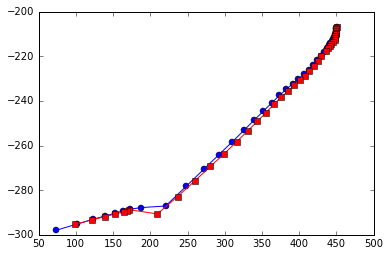

In [144]:
displayPredictedTracks(tracks,predictedTracks, 1)

In [145]:
#model.save_weights('window3_32h_weights.h5')

In [108]:
#scaler.get_params()

dict

In [109]:
#import pickle

In [110]:
#with open('scaler.pickle', 'wb') as handle:
#    pickle.dump(scaler, handle)

In [49]:
def covariance(tracks, predTracks):
    x = []
    y = []
    for (key, track) in tracks.items():
        for j, point in enumerate(track):
            x.append(point[0] - predictedTracks[key][j][0])
            y.append(point[1] - predictedTracks[key][j][1])
    x = np.matrix(x)
    y = np.matrix(y)
    m = np.concatenate((x,y), axis=0)
    print np.var(x)
    print np.var(y)
    return np.cov(m)

In [50]:
print covariance(tracks, predictedTracks)

28.0064938099
2.72131484714
[[ 28.00751973  -0.93562177]
 [ -0.93562177   2.72141453]]
